# Computacion de Funcion Hypergeometrica

```python
F(a,b;c;z) = exp(lgamma(c) - lgamma(b) - lgamma(c - b)) * z^a * (1 - z)^(c - a - b) * beta(a + 1 - c + b, c - a - b)
```

\begin{align*}
F(a,b;c;z) &= \frac{\Gamma(c)}{\Gamma(b)\Gamma(c-b)} \int_{0}^{1} t^{b-1}(1-t)^{c-b-1}(1-tz)^{-a} dt \

\end{align*}

\begin{align*}
&= \frac{\Gamma(c)}{\Gamma(b)\Gamma(c-b)} \int_{0}^{1} \frac{t^{b-1}(1-t)^{c-b-1}}{(1-tz)^{c-b}} (1-tz)^{c-b-a} dt \
\end{align*}

\begin{align*}
&= \frac{\Gamma(c)}{\Gamma(b)\Gamma(c-b)} \int_{0}^{1} \frac{(1-tz)^{c-b-a-1}}{(1-t)^{a}} t^{b-1}(1-t)^{c-b-1} dt \
&= \frac{\Gamma(c)}{\Gamma(b)\Gamma(c-b)} \int_{0}^{1} \sum_{n=0}^{\infty} \binom{n+a-1}{a-1} t^{n+b-1}(1-t)^{c-n-b-1} z^n dt \
\end{align*}

\begin{align*}
&= \sum_{n=0}^{\infty} \frac{(a)_n (b)n}{(c)_n} z^n \int_{0}^{1} \binom{n+a-1}{a-1} t^{n+b-1}(1-t)^{c-n-b-1} dt \
&= \sum_{n=0}^{\infty} \frac{(a)_n (b)_n}{(c)_n} z^n \beta(n+a,c-n-a) \

\end{align*}










Can read more in:
- Abramowitz, M. and Stegun, I. A. (1965). Handbook of Mathematical Functions with Formulas, Graphs, and Mathematical Tables. National Bureau of Standards.
- Olver, F. W. J., Lozier, D. W., Boisvert, R. F., and Clark, C. W. (2010). NIST Handbook of Mathematical Functions. Cambridge University Press.
- Wikipedia page on the Gauss hypergeometric function: https://en.wikipedia.org/wiki/Hypergeometric_function

In [16]:
import torch

#define beta function
def beta(x, y):
    return torch.exp(torch.lgamma(x) + torch.lgamma(y) - torch.lgamma(x + y))


class HyperGeomFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b, c, z):
        ctx.save_for_backward(a, b, c, z)
        result = 0
        for n in range(100):
            result += torch.exp(torch.lgamma(c) - torch.lgamma(b) - torch.lgamma(c - b)) \
                      * z.pow(n + a) * (1 - z).pow(c - a - b - n) \
                      * beta(n + a - c + b, c - a - b)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        a, b, c, z = ctx.saved_tensors
        # Derivatives of Euler's Hypergeometric function with respect to parameters a, b, c, and z
        dfda = grad_output * (HyperGeomFunction(a+1, b, c, z) - HyperGeomFunction(a, b, c, z) * (c - b - a) / z)
        dfdb = grad_output * (HyperGeomFunction(a, b+1, c, z) - HyperGeomFunction(a, b, c, z) * (b - a) / (1 - z))
        dfdc = grad_output * (HyperGeomFunction(a, b, c+1, z) - HyperGeomFunction(a, b, c, z) * (a + b - c) / (1 - z))
        dfdz = grad_output * (HyperGeomFunction(a, b, c, z) * (a / z - (c - a - b) / (1 - z)))
        return dfda, dfdb, dfdc, dfdz

def hypergeom(a, b, c, z):
    a = torch.tensor(a, requires_grad=False, dtype=torch.float64)
    b = torch.tensor(b, requires_grad=False, dtype=torch.float64)
    c = torch.tensor(c, requires_grad=False, dtype=torch.float64)
    z = torch.tensor(z, requires_grad=False, dtype=torch.float64)
    return HyperGeomFunction.apply(a, b, c, z)


In [20]:
# testing this hypergeometric
a = 1.0
b = 2.0
c = 3.0
z = torch.tensor([0.1, 0.2, 0.3])

import scipy.special
expected_output = scipy.special.hyp2f1(a, b, c, z.detach())


actual_output = hypergeom(a, b, c, z.detach()).detach().numpy()

#import numpy.testing as npt
#npt.assert_allclose(actual_output, expected_output, rtol=1e-5, atol=1e-5)
actual_output

C:\Users\fbien.DESKTOP-6FMEAR7\AppData\Local\Temp\ipykernel_5736\239533778.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, requires_grad=False, dtype=torch.float64)


array([nan, nan, nan])

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data using numpy
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Convert the data to a torch tensor
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()



## Hypergeo alternativew implementation

In [15]:
import torch
import math

# Define the beta function
def beta(x, y):
    return torch.exp(torch.lgamma(x) + torch.lgamma(y) - torch.lgamma(x + y))

# Define the forward and backward functions
class HyperGeomFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b, c, z):
        ctx.save_for_backward(a, b, c, z)
        return torch.exp(torch.lgamma(c) - torch.lgamma(b) - torch.lgamma(c - b)) \
            * z.pow(a) * (1 - z).pow(c - a - b) * beta(a + 1 - c + b, c - a - b)
    
    @staticmethod
    def backward(ctx, grad_output):
        a, b, c, z = ctx.saved_tensors
        # Derivatives of Euler's Hypergeometric function with respect to parameters a, b, c, and z
        dfda = grad_output * (HyperGeomFunction.apply(a+1, b, c, z) \
            - HyperGeomFunction.apply(a, b, c, z) * (c - b - a) / z)
        dfdb = grad_output * (HyperGeomFunction.apply(a, b+1, c, z) \
            - HyperGeomFunction.apply(a, b, c, z) * (b - a) / (1 - z))
        dfdc = grad_output * (HyperGeomFunction.apply(a, b, c+1, z) \
            - HyperGeomFunction.apply(a, b, c, z) * (a + b - c) / (1 - z))
        dfdz = grad_output * (HyperGeomFunction.apply(a, b, c, z) \
            * (a / z - (c - a - b) / (1 - z)))
        return dfda, dfdb, dfdc, dfdz


def hypergeom(a, b, c, z):
    return HyperGeomFunction.apply(a, b, c, z)


In [25]:
import matplotlib.pyplot as plt

# Generate some data using numpy
z = np.linspace(0, 0.5, 100)

# Compute the known hypergeometric function
F = (1 - z)**(-2)

# Compute the function using our implementation
a = torch.tensor(1)
b = torch.tensor(2)
c = a + b
z = torch.tensor(z)
F_hat = HyperGeomFunction.apply(a, b, c, z)


F_hat

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan], dtype=torch.float64)

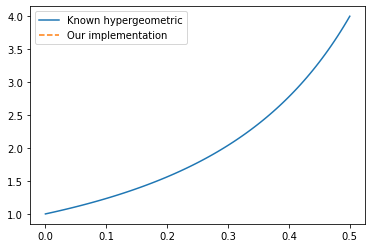

In [24]:
# Plot the results
plt.plot(z.numpy(), F, label='Known hypergeometric')
plt.plot(z.numpy(), F_hat.detach().numpy(), '--', label='Our implementation')
plt.legend()
plt.show()